In [1]:
import pandas as pd
import numpy as np
import warnings
import pyodbc
import random
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings(action = 'ignore')

#### 유전 알고리즘 활용한 페어 트레이딩 v2
- parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
- child 생성 시 볼린저밴드 파라미터와 비중 2개로 나누어 crossover
- mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle


In [2]:
conn_pcor = pyodbc.connect('driver={Oracle in OraClient18Home1};dbq=PCOR;uid=EF0SEL;pwd=EF0SEL#076')
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [3]:
os.chdir("..")
os.chdir("..")

os.chdir('00_data')

#df_const = pd.read_json('230927_index_constituent.json')
df_prc_raw = pd.read_json('230927_stk_prc_daily.json')
#df_turnover = pd.read_json('230927_stk_turnover.json')
#df_sector = pd.read_json('230927_stk_sector.json')
#df_mktcap = pd.read_json('230927_stk_mktcap.json')
#df_turnover_daily = pd.read_json('231011_stk_turnover_daily.json')

os.chdir("..")
os.chdir('02_Trading Strategies')
os.chdir('231026_유전 알고리즘을 활용한 페어트레이딩')

In [4]:
sector_code = 'IKS013'

In [5]:
sql_dt = f'''
        SELECT TRD_DT, CLOSE_PRC
        FROM TS_IDX_DAILY
        WHERE 1=1
        AND SEC_CD = '{sector_code}'
        AND TRD_DT > '20091231'
        ORDER BY TRD_DT ASC
'''

df_dt = pd.read_sql(sql_dt, conn_wisefn)

In [6]:
df_dt['TRD_DT'] =  pd.to_datetime(df_dt['TRD_DT'])
df_dt['M'] = df_dt['TRD_DT'].dt.to_period('M')
dt_m = [max(df_dt[df_dt['M']==p]['TRD_DT']) for p in df_dt['M'].unique()]
dt_m = [int(x.strftime('%Y%m%d')) for x in dt_m]

In [7]:
len(dt_m)

167

In [90]:
i = int(np.round(len(dt_m)*0.55,0))
base_d = dt_m[i]
train_begin_dt = dt_m[0]
train_end_dt = base_d

In [91]:
train_end_dt

20170929

In [92]:
sql_const = f'''
            SELECT TRD_DT, CONCAT('A',STK_CD) COMP_CD, STK_NM_KOR COMP_NM
            FROM TS_STK_ISSUE
            WHERE 1=1
            AND KS200_TYP = 1
            AND TRD_DT = '{base_d}'
            AND KSC_CD = '{sector_code}'
'''

df_const = pd.read_sql(sql_const, conn_wisefn)

In [93]:
df_train = df_prc_raw.copy()
df_train = df_train[df_train['TRD_DT'] >= train_begin_dt]
df_train = df_train[df_train['TRD_DT'] <= train_end_dt]
df_train = df_train[df_train['COMP_CD'].isin(df_const['COMP_CD'])]
df_train = df_train.sort_values(by = ['TRD_DT','COMP_CD'])
#stk_list = sorted(list(set(df_train['COMP_CD'])))


df_train = df_train.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_train = df_train.droplevel(axis = 1, level = 0)
#df_train = df_train[stk_list]
df_train.dropna(axis=1, inplace=True)
stk_list = sorted(list(df_train.columns))

In [94]:
df_train

COMP_CD,A000660,A000990,A004490,A004710,A005930,A006400,A008060,A009150,A010120,A011070,A025540,A029530,A034220,A066570
TRD_DT,,,,,,,,,,,,,,
20100129,22750.0,6080.0,21150.0,21614.52713,15680.0,136000.0,6060.0,97500.0,83800.0,86703.13042,18500.0,54100.0,37900.0,106522.70791
20100201,23100.0,5890.0,21550.0,21682.39064,15540.0,134000.0,6100.0,97600.0,80700.0,87575.00547,18300.0,53600.0,37000.0,108477.25300
20100202,22000.0,5900.0,22400.0,21682.39064,15440.0,129500.0,6030.0,94100.0,77800.0,87284.38046,17900.0,53200.0,37150.0,108477.25300
20100203,21300.0,5980.0,22650.0,21173.41434,15540.0,130000.0,6100.0,94300.0,81000.0,87865.63049,17900.0,53000.0,38000.0,110431.79810
20100204,21750.0,5940.0,22350.0,21818.11766,15520.0,131500.0,5980.0,95600.0,80100.0,85734.38036,18600.0,52500.0,37300.0,109454.52555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20170925,86300.0,14000.0,35550.0,15979.57562,53620.0,216000.0,11150.0,103500.0,54700.0,150500.00000,72500.0,62200.0,30750.0,84300.00000
20170926,82100.0,14450.0,36350.0,15795.37302,51660.0,210000.0,10950.0,101500.0,55100.0,152000.00000,74500.0,63100.0,30500.0,81800.00000
20170927,82400.0,14900.0,36000.0,15979.57562,51680.0,209500.0,10850.0,102500.0,54400.0,155500.00000,74500.0,61500.0,30550.0,81200.00000


In [95]:
df_test = df_prc_raw.copy()
df_test = df_test[df_test['TRD_DT'] >= train_end_dt]
#df_test = df_prc[df_prc['TRD_DT'] <= train_end_dt]
df_test = df_test[df_test['COMP_CD'].isin(df_const['COMP_CD'])]
df_test = df_test.sort_values(by = ['TRD_DT','COMP_CD'])

df_test = df_test.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_test = df_test.droplevel(axis = 1, level = 0)
df_test = df_test[stk_list]

In [96]:
df_test

COMP_CD,A000660,A000990,A004490,A004710,A005930,A006400,A008060,A009150,A010120,A011070,A025540,A029530,A034220,A066570
TRD_DT,,,,,,,,,,,,,,
20170929,82900.0,15300.0,35700.0,16255.87952,51280.0,198500.0,10850.0,102000.0,54100.0,154000.0,74800.0,63800.0,30550.0,82400.0
20171010,88700.0,15050.0,35300.0,16255.87952,52800.0,213500.0,10750.0,107000.0,53800.0,155000.0,74000.0,64400.0,29900.0,80800.0
20171011,89100.0,14550.0,35550.0,16209.82887,54640.0,217000.0,11050.0,105000.0,54100.0,166000.0,73100.0,64300.0,30250.0,87400.0
20171012,88500.0,14800.0,35450.0,16025.62627,54800.0,215000.0,10800.0,102500.0,55500.0,164500.0,74200.0,64800.0,28700.0,87900.0
20171013,86100.0,14350.0,35000.0,15380.91716,54000.0,216000.0,10550.0,99800.0,57300.0,163500.0,73800.0,65400.0,29000.0,88500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230921,116500.0,49050.0,61700.0,6330.00000,68900.0,538000.0,6340.0,138700.0,102000.0,243000.0,51500.0,32200.0,13250.0,102900.0
20230922,117300.0,49400.0,61400.0,6370.00000,68800.0,533000.0,6340.0,138100.0,100800.0,243000.0,53300.0,32200.0,13660.0,103100.0
20230925,117000.0,49600.0,60000.0,6250.00000,69400.0,521000.0,6290.0,138400.0,94300.0,248000.0,53000.0,32100.0,13540.0,103400.0


In [97]:
df_train.shape, df_test.shape

((1900, 14), (1475, 14))

In [98]:
def objective_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]
        
        ret = prc_2/prc_1 - 1
        ret = (ret * params_wt).sum()
        ret_list.append(ret)
        cum_ret *= (1+ret)
    
    return cum_ret

In [99]:
def generate_weight(length):
    
    pos_len = random.randint(1,length - 1)
    neg_len = length - pos_len
    
    pos_wt = []
    for i in range(pos_len):
        p = random.uniform(0,1)
        pos_wt.append(p)
    
    pos_wt = [x/sum(pos_wt) for x in pos_wt]
    
    neg_wt = []
    for i in range(neg_len):
        n = random.uniform(0,1)
        neg_wt.append(n)
    
    neg_wt = [-x/sum(neg_wt) for x in neg_wt]
    
    wt = pos_wt + neg_wt
    
    random.shuffle(wt)
    
    return wt  
        

def generate_params(df, length):
    
    params_period = random.randint(20,20*36)
    params_init = random.uniform(-4,0)
    params_exit = random.uniform(0,4)
    
    while True:
        
        params_wt = generate_weight(length)
        
        df_sp = df * params_wt
        df_sp = df_sp.sum(axis=1)

        result = adfuller(df_sp)
        p_val = result[1]
        
        if p_val < 0.05:        
            params = [params_period, params_init, params_exit, *params_wt]
            
            break

            
    return params
    

In [100]:
def generate_pop(df, size, length):
    population = []
    
    for i in range(size):
        
        params = generate_params(df,length)
        population.append(params)
        
    return population

In [101]:
def compute_performance(df, population):
    
    obj_list = []
    for individual in population:
        obj = objective_func(df, individual)
        obj_list.append([individual,obj])
    
    pop_sorted = sorted(obj_list, key=lambda x: x[1], reverse=True)
    
    return pop_sorted

In [102]:
def select_survivors(population_sorted, best_sample, lucky_few, length, df):
    
    next_gen = []
    
    for i in range(best_sample):
        if population_sorted[i][1] > 0:
            next_gen.append(population_sorted[i][0])
    
    lucky_index = np.random.choice(list(range(len(population_sorted))), lucky_few, replace=False)
    for i in lucky_index:
        next_gen.append(population_sorted[i][0])
    
    next_gen_2 = []
    for item in next_gen:
        if item not in next_gen_2:
            next_gen_2.append(item)
    
    
    while len(next_gen_2) < best_sample + lucky_few:
        next_gen_2.append(generate_params(df, length))
        
    random.shuffle(next_gen_2)
    
    return next_gen_2

In [103]:
def create_child(param1, param2):
    
    r1 = random.random()
    r2 = random.random()
    r3 = random.random()
    
    if r1 < 0.5:
        child = param1[:3] + param2[3:]
    else:
        child = param2[:3] + param1[3:]
            
    return child


def create_children(df, population, n_child):
    
    k = 1
    children = []
    
    fitness = [objective_func(df, x) for x in population]
    fitness_2 = [x if x >= 0 else 0 for x in fitness]
    
    prob = [x/sum(fitness_2) for x in fitness_2]
    

    while k < n_child:
        try:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False, p = prob)
        except:
            sample = np.random.choice(list(range(len(prob))), 2, replace=False)
        parents = [population[sample[0]], population[sample[1]]]
        
        child = create_child(parents[0], parents[1])
        children.append(child)
        
        k += 1
    
    return children

In [104]:
def mutation1(param, prob):
    
    r1 = random.random()
    r2 = random.random()
    r3 = random.random()
    
     
    if r1 < prob:
        param_period = random.randint(20,20*36)
    else:
        param_period = param[0]
           
    if r2 < prob:
        param_init = random.uniform(-4,0)
    else:
        param_init = param[1]
        
    if r3 < prob:
        param_exit = random.uniform(0,4)
    else:
        param_exit = param[2]
        
        
    param_mutate = [param_period, param_init, param_exit, *param[3:]]
    
    return param_mutate


def mutation2(param, prob):
    
    r1 = random.random()
    
    param_wt = param[3:]
    
    if r1 < prob:
        random.shuffle(param_wt)

    
    param_mutate = param[:3] + param_wt
    
    return param_mutate


################################################
def mutate_pop(population, prob1, prob2):
    
    for i in range(len(population)):
            population[i] = mutation1(population[i], prob1)
            population[i] = mutation2(population[i], prob2)
    
    return population

In [105]:
n_generation = 100
population = 100
best_sample = 25
lucky_few = 25
prob1 = 0.05
prob2 = 0.075
prob3 = 0.05
prob4 = 0.1
param_length = len(stk_list)

In [106]:
pop = generate_pop(df_train, size = population, length = param_length)

best_gene = []
best_perf = []
for g in range(n_generation):
    
    pop_sorted = compute_performance(df_train, pop)
    
    survivors = select_survivors(pop_sorted, best_sample, lucky_few, param_length, df_train)
    
    children = create_children(df_train, survivors, population)
    
    new_generation = mutate_pop(children, prob1, prob2)
    #new_generation = mutate_pop_2(children, prob)
    
    pop = new_generation
    best_gene.append(pop_sorted[0][0])
    best_perf.append(pop_sorted[0][1])
    
    print(f'====== {g}th generation ends ======')
    print(pop_sorted[0])

====== 0th generation ends ======
[[406, -1.1057346463812867, 2.256130555260479, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 2.4114739980608224]
====== 1th generation ends ======
[[237, -0.20012690294154822, 1.2956970140639967, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 2.7210767156217]
====== 2th generation ends ======
[[677, -0.2180421507022059, 0.34292580319991206, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.0145205613816913

====== 21th generation ends ======
[[653, -0.032637055275619886, 0.7415047846080629, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.0693227230033875]
====== 22th generation ends ======
[[653, -0.032637055275619886, 0.7415047846080629, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.0693227230033875]
====== 23th generation ends ======
[[653, -0.032637055275619886, 0.7415047846080629, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.01452

====== 42th generation ends ======
[[644, -0.4507448824459823, 1.3743734414738578, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.414501621253747]
====== 43th generation ends ======
[[644, -0.4507448824459823, 1.3743734414738578, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.414501621253747]
====== 44th generation ends ======
[[644, -0.4507448824459823, 1.3743734414738578, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.0145205613816

====== 63th generation ends ======
[[67, -1.6854381065199067, 2.272498191814825, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.9511727106033225]
====== 64th generation ends ======
[[67, -1.6854381065199067, 2.272498191814825, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.9511727106033225]
====== 65th generation ends ======
[[67, -1.6854381065199067, 2.272498191814825, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.01452056138169136

====== 84th generation ends ======
[[166, -1.791159666839102, 2.073839414518985, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 5.279924343771558]
====== 85th generation ends ======
[[67, -1.6854381065199067, 2.448183193518843, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 0.3645995640076629, -0.07038214372075999, -0.07990185886065247, -0.13827847631043547, -0.01642300683962267, -0.020796300556284626, -0.12976917872195956, -0.10500512174644086, -0.10169743851646967], 4.84912137307066]
====== 86th generation ends ======
[[166, -1.791159666839102, 2.073839414518985, -0.12143432387351297, 0.635400435992337, -0.10289413855862524, -0.09889745091354507, -0.014520561381691369, 

In [107]:
def simulation_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = df * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    long_ret_list = []
    short_ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]

        
        ret = prc_2/prc_1 - 1
        ret_ls = (ret * params_wt).sum()
        ret_list.append(ret_ls)        
        cum_ret *= (1+ret_ls)
        
        long_wt = [x if x >= 0 else 0 for x in params_wt]
        long_ret = (ret * long_wt).sum()
        long_ret_list.append(long_ret)
        
        short_wt = [x if x < 0 else 0 for x in params_wt]
        short_ret = (ret * short_wt).sum()
        short_ret_list.append(short_ret)
        
        
    
    return cum_ret, init_dt, exit_dt, ret_list, long_ret_list, short_ret_list

In [108]:
result_train = simulation_func(df_train,pop_sorted[0][0])

In [109]:
result_test = simulation_func(df_test,pop_sorted[0][0])

In [110]:
pop_sorted[0][0]

[166,
 -1.791159666839102,
 2.073839414518985,
 -0.12143432387351297,
 0.635400435992337,
 -0.10289413855862524,
 -0.09889745091354507,
 -0.014520561381691369,
 0.3645995640076629,
 -0.07038214372075999,
 -0.07990185886065247,
 -0.13827847631043547,
 -0.01642300683962267,
 -0.020796300556284626,
 -0.12976917872195956,
 -0.10500512174644086,
 -0.10169743851646967]

In [111]:
pd.DataFrame([stk_list, pop_sorted[0][0][3:]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,A000660,A000990,A004490,A004710,A005930,A006400,A008060,A009150,A010120,A011070,A025540,A029530,A034220,A066570
1,-0.121434,0.6354,-0.102894,-0.098897,-0.014521,0.3646,-0.070382,-0.079902,-0.138278,-0.016423,-0.020796,-0.129769,-0.105005,-0.101697


In [112]:
result_train[0], result_test[0]

(5.279924343771558, 0.9578947413500154)

In [113]:
[(x,y,z) for (x,y,z) in zip(result_train[1],result_train[2],result_train[3])]

[(20110128, 20110413, 0.4798433956877748),
 (20110923, 20120430, -0.03757133735421857),
 (20130218, 20130801, 0.09853927368483817),
 (20140806, 20150617, 1.822487778901117),
 (20161026, 20170713, 0.19562705643341052)]

In [114]:
ret_train = pd.DataFrame([result_train[3],result_train[4],result_train[5]], index = ['ls','long','short']).T
ret_train

,ls,long,short
0,0.479843,0.482500,-0.002657
1,-0.037571,0.261830,-0.299401
2,0.098539,0.111572,-0.013033
3,1.822488,1.730421,0.092067
4,0.195627,0.556209,-0.360582


In [115]:
ret_train.mean(axis=0)

ls       0.511785
long     0.628506
short   -0.116721
dtype: float64

In [116]:
(ret_train > 0).astype(int).sum()/len(ret_train)

ls       0.8
long     1.0
short    0.2
dtype: float64

In [117]:
[(x,y,z) for (x,y,z) in zip(result_test[1],result_test[2],result_test[3])]

[(20220128, 20221024, -0.04210525864998461)]

In [118]:
ret_test = pd.DataFrame([result_test[3],result_test[4],result_test[5]], index = ['ls','long','short']).T
ret_test

,ls,long,short
0,-0.042105,-0.242625,0.200519


In [119]:
ret_test.mean()

ls      -0.042105
long    -0.242625
short    0.200519
dtype: float64

In [85]:
(ret_test > 0).astype(int).sum()/len(ret_test)

ls       0.75
long     0.75
short    0.25
dtype: float64

In [86]:
result_train[3], result_test[3]

([0.28394560551485604,
  0.426806418806094,
  -0.24199604307038203,
  0.043487737540147606,
  0.12064338864939719,
  0.047734393363439,
  1.8729072391908146,
  -0.09859939738860699,
  0.2954563116936301,
  0.10349689955000968,
  -0.01758968064873866,
  0.0546528772640348,
  0.35184534233431586],
 [0.15493895050579518,
  0.4374799546142995,
  0.1763650158001573,
  -0.016771916485713804])

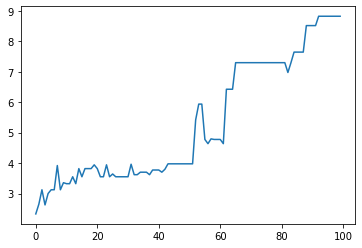

In [87]:
plt.plot(best_perf)

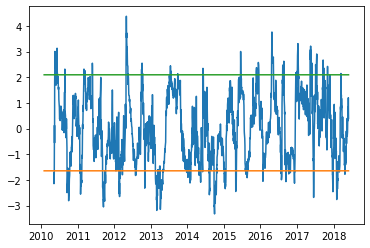

In [88]:
best_period = pop_sorted[0][0][0]
best_wt = pop_sorted[0][0][3:]

temp = (df_train*best_wt).sum(axis=1).to_frame()
temp = (temp - temp.rolling(best_period).mean())/temp.rolling(best_period).std()

temp.index = [str(x) for x in temp.index]
temp.index = pd.to_datetime(temp.index)
temp['init'] = pop_sorted[0][0][1]
temp['exit'] = pop_sorted[0][0][2]
plt.plot(temp)

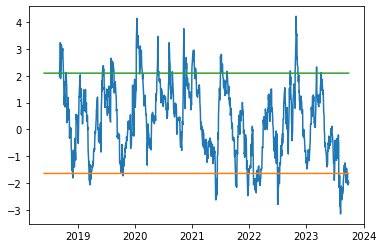

In [89]:
temp = (df_test*best_wt).sum(axis=1).to_frame()
temp = (temp - temp.rolling(best_period).mean())/temp.rolling(best_period).std()
temp.index = [str(x) for x in temp.index]
temp.index = pd.to_datetime(temp.index)
temp['init'] = pop_sorted[0][0][1]
temp['exit'] = pop_sorted[0][0][2]
plt.plot(temp)

In [137]:
pop_sorted[0][0][3:]

[-0.09598496981759405,
 0.6172526327189793,
 -0.08058818661182038,
 -0.01896096523494224,
 0.38274736728102066,
 -0.0702838009527422,
 -0.09319919133873866,
 -0.07075490689310458,
 -0.05077207758114138,
 -0.140022272687971,
 -0.04600671968939868,
 -0.05239542826575817,
 -0.10903169476789365,
 -0.033150795178432134,
 -0.13884899098046288]